<center> <img src = https://raw.githubusercontent.com/AndreyRysistov/DatasetsForPandas/main/hh%20label.jpg alt="drawing" style="width:400px;">

# <center> Проект: Анализ вакансий из HeadHunter
   

In [1]:
import pandas as pd
import psycopg2
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import requests
import json
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt

In [167]:
filename = 'linkdata.json'
# Получаем данные для конекта из json-файла, который добавлен в .gitignore
try:
    with open(filename) as f:
        link_data = json.load(f)
        
    DBNAME = link_data[0]["dbname"]
    USER = link_data[0]["user"]
    PASSWORD = link_data[0]["password"]
    HOST = link_data[0]["host"]
    PORT = link_data[0]["port"]
except FileNotFoundError:
    print(f"Sorry, the file {filename} does not exist.")
else:
    print("Данные для подключения получены.")

Данные для подключения получены.


In [169]:
# Установка коннекта 
cs = f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}:{PORT}/{DBNAME}'
engine = create_engine(cs)

# Функция для запуска запроса qtext
def queryExec(qtext):
    '''
    Функция запускает исполнение запроса, текст которого получаем через параметр qtext
    Результат возвращаем в виде dataframe. 
    Arguments:
        qtext [str]: текст запроса
    Returns:
        [DataFrame]: результирующий dataframe
    '''
    with engine.connect().execution_options(autocommit=True) as conn:
        return pd.read_sql_query(text(qtext), con=conn)

# Юнит 3. Предварительный анализ данных

1. Напишите запрос, который посчитает количество вакансий в нашей базе (вакансии находятся в таблице vacancies). 

In [131]:
# текст запроса
query_3_1 = f'''
select 
    count(*) cnt
from 
    public.vacancies
'''

In [132]:
# результат запроса
count_vacancies = queryExec(query_3_1)
display(f"Количество вакансий в базе: {count_vacancies['cnt'].iloc[0]}")

'Количество вакансий в базе: 49197'

2. Напишите запрос, который посчитает количество работодателей (таблица employers). 

In [81]:
# текст запроса
query_3_2 = f'''
select 
    count(*) cnt
from 
    public.employers
'''

In [82]:
# результат запроса
count_employers = queryExec(query_3_2)
display(f"Количество работодателей в базе: {count_employers['cnt'].iloc[0]}")

'Количество работодателей в базе: 23501'

3. Посчитате с помощью запроса количество регионов (таблица areas).

In [83]:
# текст запроса
query_3_3 = f'''
select 
    count(*) cnt
from 
    public.areas
'''

In [84]:
# результат запроса
count_areas = queryExec(query_3_3)
display(f"Количество регионов в базе: {count_areas['cnt'].iloc[0]}")

'Количество регионов в базе: 1362'

4. Посчитате с помощью запроса количество сфер деятельности в базе (таблица industries).

In [85]:
# текст запроса
query_3_4 = f'''
select
    count(*) cnt
from 
    public.industries
'''

In [86]:
# результат запроса
count_industries = queryExec(query_3_4)
display(f"Количество сфер дейтельности в базе: {count_industries['cnt'].iloc[0]}")

'Количество сфер дейтельности в базе: 294'

***

### <span style="color:magenta">Выводы по предварительному анализу данных: </span>

* В базе данных project_sql представлено 49 197 вакансий, вместе с тем, на портале HeadHunter заявлено всего 1 062 277 вакансий (на 18.03.2023 г.). Таким образом, в базе выборка менее 5% всех вакансий.
* Из 1 886 593 работодателей, размещающихся на hh.ru только 23 501 работодателя представлено в базе проекта. Из них у 8 400 не указана область деятельности, приблизительно одна треть организаций в базе. Во многих организациях, скорее всего, со сложной струтурой требуются сотрудники нескольких сфер деятельности. В 1 266 предприятий имеют отношение к 5 позициям из таблицы специальностей (отрослей). Т.о. в базе проекта только незначительная часть 1,3% от количества тех организаций, что заявлено hh.ru как участники рынка труда.
* Количество сфер деятельности (отраслей) в таблице industries равно 294. Причем к it имеют отношение около 80% всех вакансий из базы данных проекта. В общероссийской статистике около 15% всех вакансий относится к розничной торговле, в данной же базе всего около 3% вакансий относится к данной сфере деятельности. Т.о. можно сделать вывод, что данные проекта-2 не соответствуют реальным данным рынка труда. Один из доводов такого искажения будет приведен ниже в обобщающем выводе.
* Количество территориальных участков в проектной базе 1362. Здесь стоит отметить, что среди городов (приблизительно 1117 в России по данным Википедии, из них точное совпадание найдено для 706 городов), в таблице areas встречаются и населенные пункты статуса поселение. В данных присуствуют населенные пункты за пределами России. В следствие, отсутствия признака вхождения в государственные границы стран, затруднительно оценить количество таких территорий.

    В каждой вакансии указывается регион (населенный пункт), где требуются привлечь соискателей. В то же время каждый работодатель имеет привязку к региону(нам) или даже к странам. Для больших компаний, имеющих представительства или филиалы в различных регионах России указано обобщающее значение "Россия" - 410 организаций, впрочем возможно данное допущение позволяет просто не указывать более точное географическое нахождение. Из дальнего зарубежья есть работодатели из США (61), Кипр (35), Великобритания (23)



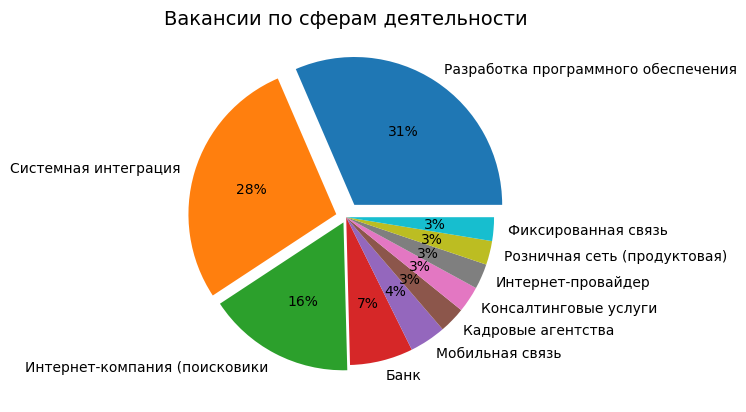

In [4]:
# Отсортированная по убыванию выборка количества вакансий по сферам деятельности
query_bonus_1 = f'''
select 
    i.name,
    count(v.*) cnt 
from 
    industries i 
join 
    employers_industries ei on ei.industry_id = i.id 
join 
    vacancies v on v.employer_id = ei.employer_id
group by 
    i.id
order by 
    cnt desc 
limit 10
'''

df_industries = queryExec(query_bonus_1)
# Получаем датасет для круговой диаграммы

fig = plt.figure()
plt.pie(df_industries['cnt'], 
        labels=df_industries['name'].apply(lambda x: x.split(',')[0]),
        explode = [0.1, 0.07, 0.04, 0, 0, 0, 0, 0, 0, 0], 
        autopct='%.0f%%')
plt.title("Вакансии по сферам деятельности", fontsize=14)
plt.show()

### Вывод:
<span style="color:pink">
    Количество вакансий в базе проекта, соотношение вакансий по сферам деятельности, с явным выделением it направления позволяет сделать вывод, что проектная база данных является выборкой для учебных целей, не отражающей реальной картины на рынке труда.</span>

<p><span style="color:pink">
    Наличие такого процента вакансий для it, можно было бы объяснить тем, что hh.ru очень популярна как площадка для поиска специалистов в данном направлении, в то время как вакансии сфер торговли или производства размещаются на других ресурсах (например в газетах), но и это предположение не может объяснить такое несоответствие с реальными, неусеченными данными.</span> </p>

<span style="color:pink">
    Работа по созданию модели на основании данных в БД project_sql оправдана только в учебных целях. </span>

# Юнит 4. Детальный анализ вакансий

1. Напишите запрос, который позволит узнать, сколько (cnt) вакансий в каждом регионе (area).
Отсортируйте по количеству вакансий в порядке убывания.

In [89]:
# текст запроса
query_4_1 = f'''
select 
    a.name, 
    count(v.id) cnt 
from 
    public.vacancies v 
join 
    public.areas a on v.area_id=a.id 
group by
    a.name 
order by count(v.id) desc
'''

In [90]:
# результат запроса
vacancies_in_areas = queryExec(query_4_1)
display(vacancies_in_areas.head(5))

,name,cnt
0,Москва,5333
1,Санкт-Петербург,2851
2,Минск,2112
3,Новосибирск,2006
4,Алматы,1892


2. Напишите запрос, чтобы определить у какого количества вакансий заполнено хотя бы одно из двух полей с зарплатой.

In [91]:
# текст запроса
query_4_2 = f'''
select 
    count(v.id) cnt
from
    public.vacancies v
where 
    v.salary_from is not NULL or v.salary_to is not NULL
'''

In [92]:
# результат запроса
vacancies_with_salary = queryExec(query_4_2)
display(f"Количество вакансий с заполнением хотябы одного из двух полей с зарплатой: {vacancies_with_salary['cnt'].iloc[0]}")

'Количество вакансий с заполнением хотябы одного из двух полей с зарплатой: 24073'

3. Найдите средние значения для нижней и верхней границы зарплатной вилки. Округлите значения до целого.

In [93]:
# текст запроса
query_4_3 = f'''
select 
    avg(v.salary_from) low_salary_limit, avg(v.salary_to) upper_salary_limit
from 
    public.vacancies v
'''

In [94]:
# результат запроса
salary_limits = queryExec(query_4_3)
display(f"Среднее значение нижней границы зарплатной вилки: {round(salary_limits['low_salary_limit'].iloc[0])}")
display(f"Среднее значение верхней границы зарплатной вилки: {round(salary_limits['upper_salary_limit'].iloc[0])}")

'Среднее значение нижней границы зарплатной вилки: 71065'

'Среднее значение верхней границы зарплатной вилки: 110537'

4. Напишите запрос, который выведет количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment), используемого в вакансиях. Результат отсортируйте по убыванию количества.


In [95]:
# текст запроса
query_4_4 = f'''
select 
    schedule, 
    employment, 
    count(id) cnt
from 
    public.vacancies
group by 
    schedule, employment
order by 
    count(id) desc
'''

In [96]:
# результат запроса
schedules_employments = queryExec(query_4_4)
display("Количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment):")
display(schedules_employments)

'Количество вакансий для каждого сочетания типа рабочего графика (schedule) и типа трудоустройства (employment):'

,schedule,employment,cnt
0,Полный день,Полная занятость,35367
1,Удаленная работа,Полная занятость,7802
2,Гибкий график,Полная занятость,1593
3,Удаленная работа,Частичная занятость,1312
4,Сменный график,Полная занятость,940
5,Полный день,Стажировка,569
6,Вахтовый метод,Полная занятость,367
7,Полный день,Частичная занятость,347
8,Гибкий график,Частичная занятость,312
9,Полный день,Проектная работа,141


5. Напишите запрос, выводящий значения поля Требуемый опыт работы (experience) в порядке возрастания количества вакансий, в которых указан данный вариант опыта. 

In [97]:
# текст запроса
query_4_5 = f'''
select 
    experience, 
    count(id) cnt
from 
    public.vacancies
group by 
    experience
order by 
    count(id)
'''

In [98]:
# результат запроса
stats_experience = queryExec(query_4_5)
display("Требуемый опыт работы (experience) в порядке возрастания количества вакансий:")
display(stats_experience)

'Требуемый опыт работы (experience) в порядке возрастания количества вакансий:'

,experience,cnt
0,Более 6 лет,1337
1,Нет опыта,7197
2,От 3 до 6 лет,14511
3,От 1 года до 3 лет,26152


***

### <span style="color:magenta"> Выводы по детальному анализу вакансий </span>

* Максимальное число вакансий находится в Москве, вследствие популяции города, уровня зарплат, уровня благоустроенности и прочих "плюшек" столицы страны. По этим же соображениям на 2-м и 3-м месте находятся Северная столица России и Минск. Вообще на российские города миллионики приходится 23 856 (48%), вцелом на города-миллионики, в том чиле стран ближнего зарубежья, приходится 29 456 вакансий (почти 60% всех вакансий в базе проекта). Т.о. требуются соискатели на 5 600 вакансий в городах независимых государств. 

* В 49% вакансий упоминается предлагаемая заработная плата. В среднем нижняя граница более 70 тыс. руб., а верхняя более 110 тыс. руб. В грубом сравнении с цифрами Росстата, средняя з/п по России 62 270 руб в текущем году, при этом выше 100 тыс. рублей зарплаты можно найти только в регионах: ЯНАО, Магаданской обл., Чукотском АО и в г. Москва. Т.о. здесь присутствует явное смещение предлагаемых зарплат к более высокому уровню.

* В 72% вакансий запрашивается график работы/занятость: Полный день/Полная занятость. При этом в 16% предложений указана удаленная работа с полной занятостью - наследие короновирусного периода, из-за которого выявилось множество положительных моментов такого "стиля" работы вследствии еще и появления или усовершенствования интрументов для удаленной полноценной работы и более глубого внеднения различных подходов к управлению проектами.

* 53% предложений из проектной базы запрашивают опыт работы более 1 года и менее 3 лет. Почти 30% вакансий содержат требование о стаже работы от 3 до 6-ти лет. Без опыта работы 14.6% предложений. Предпочтение на более молодой возраст, но уже получившее некоторый боевой опыт или представление о работе в специальности, способный к обучению. В 30 случаях из 100 требуются уже специалисты из категории профессионалы, но вместе с тем не потерявшие "гибкость" в сравнении с профессионалами с более чем 6 годами стажа работы.


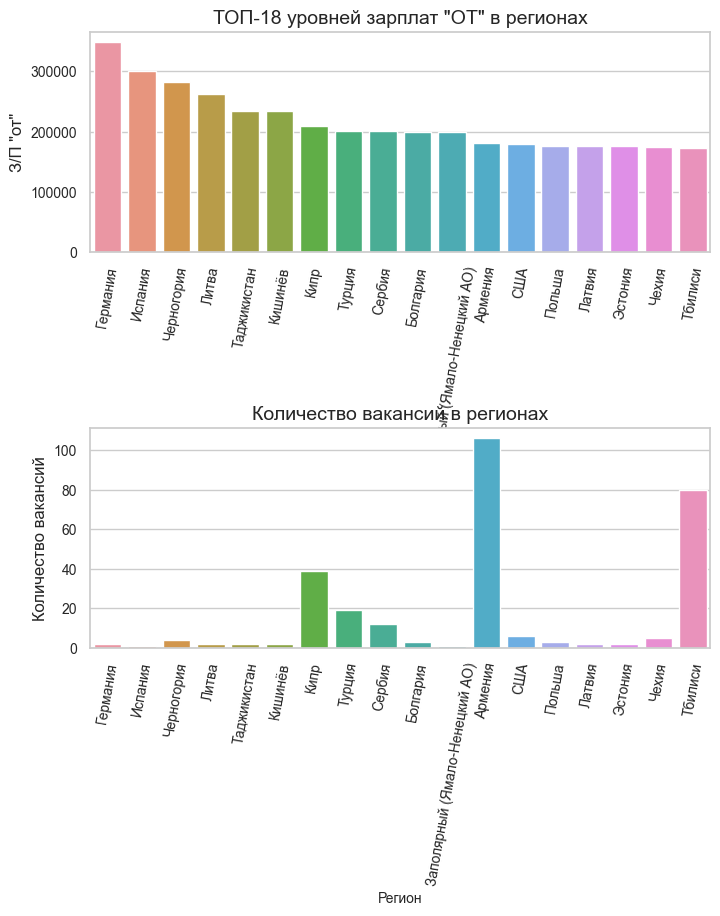

In [132]:
# доп. исследование по зарплатам

query_bonus_2 = f'''
select 
    a.name, 
    coalesce(round(avg(v.salary_from)),0) from_sal, 
    coalesce(round(avg(v.salary_to)), 0) to_sal,
    count(v.id) cnt
from 
    public.vacancies v 
join 
    public.areas a on a.id = v.area_id 
where 
    v.salary_from is not NULL or v.salary_to is not NULL
group by 
    a.id
order by 
    from_sal desc, cnt desc
limit 18
'''

df_salary = queryExec(query_bonus_2)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
fig1 = sns.barplot(x='name', y='from_sal', data=df_salary)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=80)
fig1.set_xlabel("Регион", fontsize=10)
fig1.set_ylabel('З/П "от"', fontsize=12)
fig1.set_title('ТОП-18 уровней зарплат "ОТ" в регионах', fontsize=14)


plt.subplot(2, 1, 2)
fig2 = sns.barplot(y='cnt', x='name', data=df_salary)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=80)
fig2.set_ylabel("Количество вакансий", fontsize=12)
fig2.set_xlabel("Регион", fontsize=10)
fig2.set_title('Количество вакансий в регионах', fontsize=14)


plt.subplots_adjust(hspace = 0.8)
plt.show()

### Выводы:
<span style="color:pink">
С учетом того, что база проекта представляет собой выборку вакансий, где более 70% относится к it напралению, стоит отметить, что предлагаемая З\П в вакансиях (если она указана) в какой-то мере выше З\П по данным Росстата. Из предыдушей диаграммы видно, что самые высокие З\П предлагаются в основном за пределами России, но в основном это единичные предложения, на общем фоне можно отметить Армению (106 вакансий), Грузию (80 вакансий), Кипр (39), Турция (19). В России предложения с более высоким заявленном уровнем З\П в Москве, ЯНАО, Санкт-Петербуг, Магаданская обл., Чукотский АО.</span>
<p><span style="color:pink">
Важно при этом учитывать, что З/П явно указывается почти в половине вакансий. Возможно компании либо не хотят отпугнуть соискателей, либо пытаются больше оставить себе места для маневра при попытке договорится об оплате "на лету".</span></p>
<span style="color:pink">
На города-миллионики приходится почти 60% всех вакансий, где топ-3: Москва, Санкт-Петербург и Минск.</span>

<p><span style="color:pink">
73% предложений с графиком работы "Полный день/Полная занятость", 16% предложений по "удаленке" с полной занятостью. Такой высокий процент предложений по удаленнке объясняется большим количество вакансий для it-специалистов.</span></p>


# Юнит 5. Анализ работодателей

1. Напишите запрос, который позволит узнать, какие работодатели находятся на первом и пятом месте по количеству вакансий.

In [99]:
# текст запроса
query_5_1 = f'''
select 
    e.name,
    count(v.id) cnt
from 
    public.employers e 
join    
    public.vacancies v on e.id = v.employer_id
group by 
    e.id 
order by count(v.id) desc 
limit 5
'''

In [100]:
# результат запроса
empoyers_top5 = queryExec(query_5_1)
display(f"первый работотадель по кол-ву вакансий: {empoyers_top5['name'].iloc[0]}")
display(f"пятый работотадель по кол-ву вакансий: {empoyers_top5['name'].iloc[4]}")

'первый работотадель по кол-ву вакансий: Яндекс'

'пятый работотадель по кол-ву вакансий: Газпром нефть'

2. Напишите запрос, который для каждого региона выведет количество работодателей и вакансий в нём.
Среди регионов, в которых нет вакансий, найдите тот, в котором наибольшее количество работодателей.


In [102]:
# текст запроса
query_5_2 = f'''
select 
    a.name,
    count(v.name) cnt_vacations,
    count(disctinct e.id) cnt_employers
from 
    public.areas a 
left join 
    public.vacancies v on v.area_id = a.id 
left join 
    public.employers e on e.area = a.id
where
    v.id is null
group by 
    a.id 
order by 
    cnt_employers desc
limit 1 
'''

In [103]:
# результат запроса
area_without_vacs = queryExec(query_5_2)
display(f"Регион без вакансий: {area_without_vacs['name'].iloc[0]},\
    где присутствует {area_without_vacs['cnt_employers'].iloc[0]} работодателей")

'Регион без вакансий: Россия,    где присутствует 410 работодателей'

3. Для каждого работодателя посчитайте количество регионов, в которых он публикует свои вакансии. Отсортируйте результат по убыванию количества.


In [142]:
# текст запроса
query_5_3 = f'''
select 
    e.name,
    count(distinct v.area_id) cnt_areas
from 
    public.employers e 
join 
    public.vacancies v on v.employer_id = e.id 
group by 
    e.id
order by 
    cnt_areas desc    

'''

In [139]:
# результат запроса
employer_max_areas = queryExec(query_5_3)
display(f"Максимальное количество регионов размещения = {employer_max_areas['cnt_areas'].iloc[0]}\
    у {employer_max_areas['name'].iloc[0]}а")

'Максимальное количество регионов размещения = 181    у Яндекса'

4. Напишите запрос для подсчёта количества работодателей, у которых не указана сфера деятельности. 

In [106]:
# текст запроса
query_5_4 = f'''
select 
    count(e.name) cnt
from 
    public.employers e 
where 
    e.id not in (select employer_id from public.employers_industries)
'''

In [107]:
# результат запроса
cnt_empls_wout_indst = queryExec(query_5_4)
display(f"Количество работодателей без указания сферы деятельности: {cnt_empls_wout_indst['cnt'].iloc[0]}")

'Количество работодателей без указания сферы деятельности: 8419'

5. Напишите запрос, чтобы узнать название компании, находящейся на третьем месте в алфавитном списке (по названию) компаний, у которых указано четыре сферы деятельности. 

In [108]:
# текст запроса
count_industries = 4
query_5_5 = f'''
select 
    e.name, 
    count(i.id) cnt
from 
    public.employers e 
join 
    public.employers_industries e_i on e_i.employer_id = e.id 
join 
    public.industries i on i.id = e_i.industry_id
group by 
    e.id 
having 
    count(i.id) = {count_industries}
order by 
    e.name 
offset 2 limit 1
'''

In [109]:
# результат запроса
employ_in4_indust = queryExec(query_5_5)
display(f"Компания {employ_in4_indust['name'].iloc[0]} работает в 4-х сферах деятельности.")

'Компания 2ГИС работает в 4-х сферах деятельности.'

6. С помощью запроса выясните, у какого количества работодателей в качестве сферы деятельности указана Разработка программного обеспечения.


In [110]:
# текст запроса
industry = 'Разработка программного обеспечения'
query_5_6 = f'''
select 
   count(e.name) cnt
from 
    public.employers e 
join 
    public.employers_industries e_i on e_i.employer_id = e.id 
join 
    public.industries i on i.id = e_i.industry_id
where 
    i.name = '{industry}'
'''

In [111]:
# результат запроса
cnt_employers_dev = queryExec(query_5_6)
display(f"Количество компаний разработчиков ПО: {cnt_employers_dev['cnt'].iloc[0]}")

'Количество компаний разработчиков ПО: 3553'

7. Для компании «Яндекс» выведите список регионов-миллионников, в которых представлены вакансии компании, вместе с количеством вакансий в этих регионах. Также добавьте строку Total с общим количеством вакансий компании. Результат отсортируйте по возрастанию количества.

Список городов-милионников надо взять [отсюда](https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8). 

Если возникнут трудности с этим задание посмотрите материалы модуля  PYTHON-17. Как получать данные из веб-источников и API. 

In [94]:
# код для получения списка городов-милионников
url = 'https://ru.wikipedia.org/wiki/Города-миллионеры_России'
response = requests.get(url)
# Подготавливаем нулевую строку для списка городов
cities_list = ""
page = BeautifulSoup(response.text, 'html.parser')
# Выбираем нужную таблицу класса standart...
table = page.find('table',class_='standard')
# Перебераем все ссылки в таблице, учитывая, что родителем ссылки является столбец
for ahead in table.findAll('a'):
  if ahead.parent.name == 'td':
     cities_list = cities_list + '\'' + ahead["title"] + '\','
# Из каждой ссылки был вытянут title и добавлен в строку-лимонников
# Формируем строку по формату 'город 1', ...,'город n' для запроса   
cities_list = cities_list[0: len(cities_list)-1]  

cities_list

"'Москва','Санкт-Петербург','Новосибирск','Екатеринбург','Казань','Нижний Новгород','Челябинск','Красноярск','Самара','Уфа','Ростов-на-Дону','Омск','Краснодар','Воронеж','Пермь','Волгоград'"

In [95]:
# текст запроса
company = 'Яндекс'
query_5_7 = f'''
(
select 
    a.name,
    count(v.id) cnt
from 
    public.employers e 
join
    public.vacancies v on v.employer_id = e.id and e.name = '{company}'
join 
    public.areas a on a.id = v.area_id and a.name in ({cities_list})
group by 
    a.id 
)
union all
(
select 
    'Total', count(*)
from 
 public.employers e 
join
    public.vacancies v on v.employer_id = e.id and e.name = '{company}'
join 
    public.areas a on a.id = v.area_id and a.name in ({cities_list})
)
order by cnt
'''

In [96]:
# результат запроса
display('Список регионов-миллиоников, где присуствует Яндекс и кол-во вакансий в них:')
yandex_cities = queryExec(query_5_7)
display(yandex_cities)

'Список регионов-миллиоников, где присуствует Яндекс и кол-во вакансий в них:'

,name,cnt
0,Омск,21
1,Челябинск,22
2,Красноярск,23
3,Волгоград,24
4,Пермь,25
5,Казань,25
6,Ростов-на-Дону,25
7,Самара,26
8,Уфа,26
9,Краснодар,30


***

### <span style="color:magenta"> Выводы по детальному анализу работодателей </span>

* В необъятной России 11 часовых поясов, для компаний масшатба страны, логично предположить наличие хотябы одного присутствия в каждом часовом поясе как минимум. Кроме того Российская федерация состоит из 85 субъектов.
Количество размещаемых вакансий находится в прямой зависимости от того, к какому бизнесу (мелкий бизнес, средний бизнес, крупнный бизнес) относится работодатель. Крупные национальные компании разыскивают большое количество различных специалистов в разных регионах.
Примером являются лидеры по количеству размещенных вакансий и количеству регионов, где разыскиваются будующие сотрудники, является Яндекс и Ростелеком.
Яндекс разместило 1933 вакансии в 181 населенном пунке. Ростелеком размещает 491 вакансию в 152 насел. пункте.

* Для примера можно взять в фокус Яндекс, существует целое облоко сервисов, среди которых есть в том числе и Яндекс.Маркет, Яндекс.Такси итд. Таким образом Яндекс является материнской компанией, которая расположена в Москве, а все выше перечисленные сервисы как бы подразделения, которые присутствуют во всех крупных центрах, в том числе городах административного значения, не являющимися миллионниками. 

* В топе работодателей по количеству вакансий присутствуют банки: Тинькофф, СБЕР, Совкомбанк. Каждый банк имеет свои филиалы и отделения. Если взять Тинькофф, то основная особенность работа он-лайн и невидимое присутствие без характерных банкам офисов с отрядами менеджеров, кассиров и рассчетников. Но даже для такого банка можно найти информацию о его работе в 79 городах России, филиальная сеть банка составляет 58 отделений и 245 банкоматов по всей России. Явный упор на он-лайн обслуживание банка Тинькофф по сравнению с др. банками отчасти объясняет наибольшее количество вакансий с удаленным графиком работы (ниже приведена диаграмма).

* В близи каждого административного центра, находятся небольшие города-спутники. Работодатель может указать такие локации по географическому принципу: допустим радиус в 60 км.
В 331 локациях, где нет работодателей размещены 723 вакансии, что объяснимо тем, что представительство данных организаций находится в более крупных населенных пунктах (возможно городах-миллиониках), находящихся по соседству.

* Только 36% всех работодателей проектной базы указали сферу деятельности. Одной из причин пропуска в поле сферы деятельности возможно является нежелание усечения своего поля деятельности. Одна и та же компания может отметить несколько пунктов из перечня всех сфер: 2 384 компании указали 4 и более сфер своей деятельности. Из всех 23 501 компаний работодателей 3 553 компаний заявлены как разработчики программного обеспечения (что составляет 15%). 

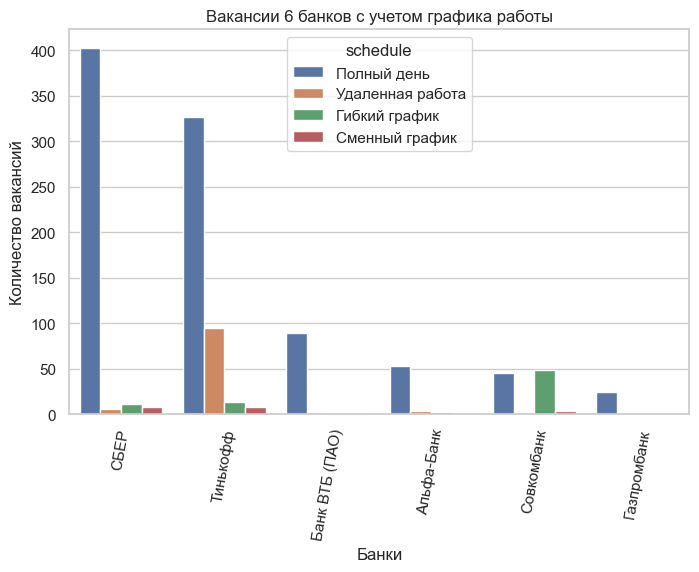

In [161]:
query_bonus_3  = f'''
select 
    e.name bank, 
    v.schedule, 
    count(v.schedule) cnt
from 
    public.employers e 
join 
    vacancies v on v.employer_id = e.id
join 
    areas a on a.id = v.area_id
where 
    e.name in ('Тинькофф', 'СБЕР', 'Совкомбанк', 'Газпромбанк', 'Альфа-Банк', 'Банк ВТБ (ПАО)')
group by 
    e.name, v.schedule
order by 
    cnt desc, v.schedule
    
'''

df_banks = queryExec(query_bonus_3)

plt.figure(figsize=(8, 5))
ax = sns.barplot(df_banks, x='bank', y='cnt', hue='schedule')
plt.xticks(rotation=80)
ax.set_title("Вакансии 6 банков с учетом графика работы", fontsize=12)
ax.set_xlabel("Банки", fontsize=12)
ax.set_ylabel("Количество вакансий", fontsize=12)

plt.show()

# Юнит 6. Предметный анализ

1. Сколько вакансий имеет отношение к данным?

Считаем, что вакансия имеет отношение к данным, если в её названии содержатся слова 'data' или 'данн'.

*Подсказка: Обратите внимание, что названия вакансий могут быть написаны в любом регистре.* 


In [115]:
# текст запроса
param_1 = 'data'
param_2 = 'данн'

query_6_1 = f'''
select 
    count(*) cnt
from 
    public.vacancies
where 
    lower(name) like '%{param_1}%' or lower(name) like '%{param_2}%'
'''

In [116]:
# результат запроса
count_vacancies_ds = queryExec(query_6_1)
display(f"Количество вакансий имеющих отношение к данным: {count_vacancies_ds['cnt'].iloc[0]}")

'Количество вакансий имеющих отношение к данным: 1771'

2. Сколько есть подходящих вакансий для начинающего дата-сайентиста? 
Будем считать вакансиями для дата-сайентистов такие, в названии которых есть хотя бы одно из следующих сочетаний:
* 'data scientist'
* 'data science'
* 'исследователь данных'
* 'ML' (здесь не нужно брать вакансии по HTML)
* 'machine learning'
* 'машинн%обучен%'

** В следующих заданиях мы продолжим работать с вакансиями по этому условию.*

Считаем вакансиями для специалистов уровня Junior следующие:
* в названии есть слово 'junior' *или*
* требуемый опыт — Нет опыта *или*
* тип трудоустройства — Стажировка.
 

In [118]:
# Список подстрок - параметров для запроса
param_list = ['data scientist','data science','исследователь данных','machine learning','машинн%обучен%']
# Объединяем в единую строку для последующего использования в sql query
param_string = ('|').join(param_list)

# текст запроса
query_6_2 = f'''
select 
    count(*) cnt
from 
    public.vacancies
where 
    (lower(name) similar to '%({param_string})%' or
    name like '%ML%')
    and position('html' in lower(name)) = 0
    and (position('junior' in lower(name)) > 0 or 
        experience = 'Нет опыта' or
        employment = 'Стажировка')
'''

In [119]:
# результат запроса
count_vacancies_jun = queryExec(query_6_2)
display(f"Количество вакансий для начинающего дата-сайентиста: {count_vacancies_jun['cnt'].iloc[0]}")

'Количество вакансий для начинающего дата-сайентиста: 51'

3. Сколько есть вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres?

** Критерии для отнесения вакансии к DS указаны в предыдущем задании.*

In [120]:
# текст запроса
query_6_3 = f'''
select 
    count(*) cnt
from 
    public.vacancies
where 
    (lower(name) similar to '%({param_string})%' or
    name like '%ML%')
    and position('html' in lower(name)) = 0
    and (position('sql' in lower(key_skills)) > 0 or 
        position('postgres' in lower(key_skills)) > 0)
'''

In [121]:
# результат запроса
count_ds_vacations = queryExec(query_6_3)
display(f"Количество вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres: \
    {count_ds_vacations['cnt'].iloc[0]}")

'Количество вакансий для DS, в которых в качестве ключевого навыка указан SQL или postgres:     201'

4. Проверьте, насколько популярен Python в требованиях работодателей к DS.Для этого вычислите количество вакансий, в которых в качестве ключевого навыка указан Python.

** Это можно сделать помощью запроса, аналогичного предыдущему.*

In [122]:
# текст запроса
query_6_4 = f'''
select 
    count(*) cnt
from 
    public.vacancies
where 
    (lower(name) similar to '%({param_string})%'
    or name like '%ML%')
    and position('html' in lower(name)) = 0
    and position('python' in lower(key_skills)) > 0
'''

In [123]:
# результат запроса
count_python_vacations = queryExec(query_6_4)
display(f"Количество DS вакансий с навыком Python: {count_python_vacations['cnt'].iloc[0]}")

'Количество DS вакансий с навыком Python: 351'

5. Сколько ключевых навыков в среднем указывают в вакансиях для DS?
Ответ округлите до двух знаков после точки-разделителя.

In [124]:
# текст запроса
query_6_5 = f'''
select 
    avg(length(key_skills)-length(replace(key_skills, CHR(9), '')) + 1) avg_skills
from 
    public.vacancies
where 
    (lower(name) similar to '%(data scientist|data science|исследователь данных|machine learning|машинн%обучен%)%'
    or name like '%ML%')
    and position('html' in lower(name)) = 0
    and key_skills is not null
'''

In [125]:
# результат запроса
count_skills = queryExec(query_6_5)
display(f"Срееднее значение ключевых навыков в вакансиях DS-специалистов:\
    {round(count_skills['avg_skills'].iloc[0], 2)}")

'Срееднее значение ключевых навыков в вакансиях DS-специалистов:    6.41'

6. Напишите запрос, позволяющий вычислить, какую зарплату для DS в **среднем** указывают для каждого типа требуемого опыта (уникальное значение из поля *experience*). 

При решении задачи примите во внимание следующее:
1. Рассматриваем только вакансии, у которых заполнено хотя бы одно из двух полей с зарплатой.
2. Если заполнены оба поля с зарплатой, то считаем зарплату по каждой вакансии как сумму двух полей, делённую на 2. Если заполнено только одно из полей, то его и считаем зарплатой по вакансии.
3. Если в расчётах участвует null, в результате он тоже даст null (посмотрите, что возвращает запрос select 1 + null). Чтобы избежать этой ситуацию, мы воспользуемся функцией [coalesce](https://postgrespro.ru/docs/postgresql/9.5/functions-conditional#functions-coalesce-nvl-ifnull), которая заменит null на значение, которое мы передадим. Например, посмотрите, что возвращает запрос `select 1 + coalesce(null, 0)`

Выясните, на какую зарплату в среднем может рассчитывать дата-сайентист с опытом работы от 3 до 6 лет. Результат округлите до целого числа. 

In [126]:
# текст запроса
query_6_6 = f'''
select 
    experience, 
    avg(case
        when (salary_from is not null) and (salary_to is not null) then (salary_from + salary_to)/2
        when (salary_from is null) and (salary_to is not null) then salary_to
        when (salary_from is not null) and (salary_to is null) then salary_from
    end) salary
from 
    public.vacancies
where 
    (lower(name) similar to '%(data scientist|data science|исследователь данных|machine learning|машинн%обучен%)%'
    or name like '%ML%')
    and position('html' in lower(name)) = 0
    and (salary_from is not null or salary_to is not null)
group by 
    experience
'''

In [127]:
# результат запроса
avg_DS_salary = queryExec(query_6_6)
display(f"Средняя зарплата для DS-специалиста с опытом работы от 3 до 6 лет:\
    {round(avg_DS_salary[avg_DS_salary['experience']=='От 3 до 6 лет']['salary'].iloc[0])} руб.")

'Средняя зарплата для DS-специалиста с опытом работы от 3 до 6 лет:    243115 руб.'

***

### <span style="color:magenta"> Выводы по предметному анализу: </span>

* Количество выявленных вакансий, имеющих отношение к данными: 1 771, что составляет 3,6 % от всех вакансий в данной проектной базе  из них 431 вакансий DS и только 15 явных вакансия для начинающего DS специалиста.  Т.о. почти 12% вакансий для датасайентистов, для новичков в данной сфере. Можно объяснить такой факт тем, что данное направление относительно недавно претерпело классификацию по специальностям работы с данными, хотя вообщем то данный процесс еще и не завершен, скорее всего. Изменения и появление новые технологий опережают такой инертный процесс как подготовка новых кадров с фиксированными навыками.
 
    Т.е. вывод такой, что традиционная методика по подготовке специалиста не успевает за новыми требования для работы с самыми современными технологиями, без использования которых грозит предприям проиграть конкуренцию и начать регрессию с последующей "гибелью". Поэтому зачастую датасайнтисты "рождаются и развиваются" уже в "боевых условиях".

 * 201 вакансия из 431 вакансий по DS, включают требование навыков работы на SQL или знание postgre, почти 47%, означает, что будущим DS-специалистам стоит освоить SQL для того, чтобы увеличить шанс получения работы по данной специальности. Умение получать необходимые данные и навыки эффективного взаимодействия с БД очень ценный навык, т.к. скорее всего, не все организации могу себе позволить инженера данных. 

 * Требование знание Python для DS упоминается почти в вакансиях 82%. Вывод очевиден в пользу серьезного осваивания Python.  

* Уровне З\П существенным образом отличаются от  опыта работы: 75 тыс. рублей для новичков, почти 140 тыс. рублей для специалистов со стажем до 3 лет и 243 тыс. рублей для специалистов с опытом работы более чем 3 года. Глядя на предлагаемые зарплаты для новичков, наверно трудно себя мотировать на изучение данной дисциплины, не беря в расчет того, что данное направление изучать очень-очень интересно. Но в течение 3 лет есть возможность найти проект уже с учетом пройденного пути.

* **Для дополнительного исследования выбран анализ требуемых навыков для специалистов DS. Какие навыки на момент актуальности проектной базы в спросе:**

,skill,count
164,Python,348
47,Sql,191
240,Machine Learning,140
337,Git,66
382,Data Science,64
105,Математическая Статистика,62
277,Pytorch,61
387,Pandas,55
363,Data Analysis,54
103,Ml,49


Text(0.5, 1.0, 'Количество требуемых навыков. TOP-15')

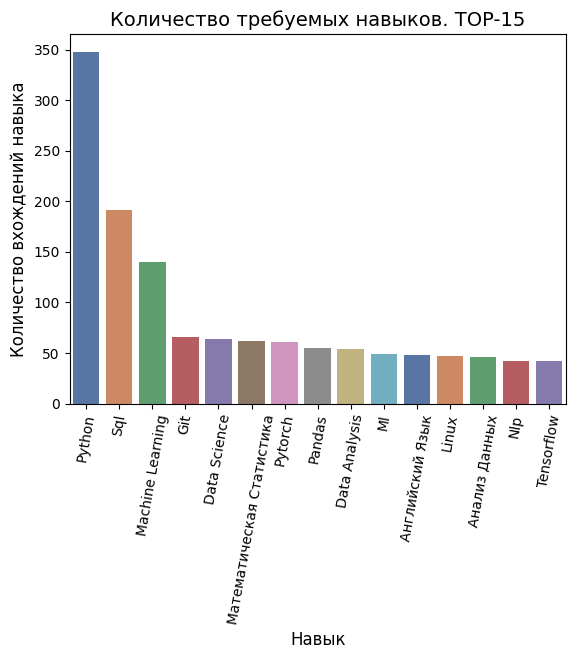

In [174]:
# Запрос на доп. исследование требуемых навыков для DS специалистов
query_bonus_4 = f''' 
select 
    key_skills
from 
    public.vacancies
where 
    (lower(name) similar to '%(data scientist|data science|исследователь данных|machine learning|машинн%обучен%)%'
    or name like '%ML%')
    and position('html' in lower(name)) = 0
    and key_skills is not null
'''
# Получаем рабочий DF для исследования навыков
df = queryExec(query_bonus_4)

# Проведем подготовку данных
skill_list = []
for skill in df['key_skills']:
    # Каждый навык приводим к строчным и сплитуем по разделителю
    temp_list = skill.lower().split('\t')
    skill_list.extend(temp_list)
    
# Убираем явные дубликаты через множество    
skills = list(set(skill_list))

# Создаем словарь вхождений навыка:
skill_rating = {}
# ключ - текущий навык, значение - количество вхождений 
# # в первоначальный список всех навыков для DS
for skill in skills:
    for val in skill_list:
        if skill == val:
            if skill in skill_rating:
                skill_rating[skill] += 1
            else:
                skill_rating[skill] = 1
                
# Создаем датафрейм из полученного словаря    
target_df = pd.DataFrame(list(skill_rating.items()), columns = ['skill', 'count'])
# Приведем название навыков к более "благородному" виду
target_df['skill'] = target_df['skill'].apply(lambda x: x.title())
# Осортируем по убыванию вхождений и возьмем только первые 15 позиций
target_df = target_df.sort_values(by='count',ascending=False).head(15)

display(target_df)

# Построим для наглядности столбчатую диаграмму 
fig_bonus_4 = sns.barplot(y='count', x='skill', data=target_df, palette=sns.color_palette("deep"))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xticks(rotation=80)
fig_bonus_4.set_ylabel("Количество вхождений навыка", fontsize=12)
fig_bonus_4.set_xlabel("Навык", fontsize=12)
fig_bonus_4.set_title('Количество требуемых навыков. TOP-15', fontsize=14)

### Вывод по доп. исследованию

**В топ-3 входят ожидаемые навыки: Python, SQL и Машинное обучение.**

**Навыки работы с системой контроля версий git запрашиваются чаще чем статистика и самые популярные библиотеки аналитиков.**

**В топ-10 входит знание английского языка. Данный навык трудно переоценить для датасайнтиста. Для прогрессивного эволюционирования к изучению обязателен.**

---

# <span style="color:red"> **Общий вывод по проекту** </span>

В проектной базе данных содержится чуть меньше 50 тыс. вакансий, приблизительно 80% из них относятся так или иначе к it направлению. 
Половина вакансий содержит сведения о предлагаемых зарплатах на рынке труда, в среднем нижняя граница вилки приблизительно чуть больше 70 тыс. рублей, а верхняя граница выше 100 тыс. рублей. Самые высокие заработные платы предлагаются из зарубежа: Германия, Испания, Черногория, Кипр, Турция, Армения, Прибалтийские страны, Грузия, Польша, Чехия. Правда количество "забугорных" вакансий незначительно, больше всего таких вакансий из Арменнии (больше 100) и из Грузии (80 вакансий). 

В пределах Российской федерации и стран очень ближнего зарубежья самые высокие З\П предлагаются в ЯНАО, Магаданской обл., Чукотском АО, в Москве, Санкт-Петербурге, Минске. По количеству вакансий больше всего предложений из Москвы, СПб и Минска. Если остановиться на географии, то 60% вакансий расчитаны на соискателей из городов-миллиоников. 
Данные из таблицы vacations позволяют сделать вывод, что в 72 вакансиях из 100 предлагается график работы полный день с полной занятостью и в 16 вакансиях, в этом же соотношении, предложена удаленная работа с полной занятностью. А самый запрашиваемы опыт работы от 1 года до 3 лет.

В базе присутсвуют работодатели, которые присутствуют в 5-ти сферах деятельности. А такие компании как Яндекс, Ростелеком, ведующие банки присутстуют почти во всех регионах Р.Ф. В дополнительном исследовании есть "картинка" предлагамой работы, с учетом графика работы и занятости. Например, Тинькофф разместил больше всех банков предложения по работе на удаленке. 


Весьма узкая полоска в 3,6% вакансий предназначена для тех, кто работает с данными. И всего около 430 вакансий из 49 тыс. нацелены на датасайентистов, где половина вакансий требует навыка работы на SQL (или в Postgre). И самый искомый навык для датасайнтиста это навык работы на Python (82% вакансий для DS). При работе в DS больше года, можно рассчитывать на З/П в в среднем 140 тыс. рублей, а при опыте более 3 лет на 240 тыс. рублей (в среднем).


**Основной вывод: для успешной работы в DS, жизненно необходим Python. А для успешного и быстрого поиска своего будущего работодателя необходимо знание SQL и Git. И особенно важно как можно быстрее начать наращивать опыт работы, учавствуя в рабочих проектах.  240 тыс. рублей и интересная работа вполне адекватный стимул для этого.**